In [46]:
import torch
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [81]:
def plot_forward(net, conductivity=None, heat_source=None):
    time_index = int(input("Enter time_index: "))
    if time_index == 999:
        return
    x = np.arange(0, 2, 0.02)
    y = np.arange(0, 2, 0.02)
    t = np.arange(0, 1, 0.01)

    ms_x, ms_y, ms_t = np.meshgrid(x, y, t, indexing="ij")  # Ensure correct indexing
    x_all = ms_x.ravel().reshape(-1, 1)
    y_all = ms_y.ravel().reshape(-1, 1)
    t_all = ms_t.ravel().reshape(-1, 1)

    pt_x = Variable(torch.from_numpy(x_all).float(), requires_grad=False).to(device)
    pt_y = Variable(torch.from_numpy(y_all).float(), requires_grad=False).to(device)
    pt_t = Variable(torch.from_numpy(t_all).float(), requires_grad=False).to(device)

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    pt_u = net(pt_x, pt_y, pt_t)
    u = pt_u.data.cpu().numpy()
    ms_u = u.reshape((100, 100, 100))[:, :, time_index]  # Extract 2D slice

    # Ensure ms_x and ms_y are also 2D for the same time index
    ms_x_2d = ms_x[:, :, time_index]
    ms_y_2d = ms_y[:, :, time_index]

    surf = ax.plot_surface(ms_x_2d, ms_y_2d, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.4, aspect=5)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("Temperature u(x,y)")
    plt.title(f"Temperature at t={t[time_index]:.2f}")
    plt.show()



**Definition du probleme de transfert de chaleur**

In [90]:
class forward_problem:
  def __init__(self,net=None):
    #la variable net sera la fonction de regression qui approximera le champ de chaleur
    if net is not None:
      self.net = net

  def heat_source(self,x,y,t):
    #la valeur du terme source de chaleur q(x,t), qui peut etre dans un premier temps zero partout
    q = 0

    return q

  def advection(self,x,y,t,u, beta, uref):
    #la valeur du terme d'advection
    q = beta*(u-uref)

    return q

  def conductivity(self,x,y):
    k = 1

    return k

  def heat_capacity(self,x,y):
    #la chaleur specifique qui peut varier dans le milieu; par defaut, constante et egale à 1
    c = 1

    return c

  def ic(self,x,y):
    #conditions initiales
    ic = 0

    return ic

  def bc(self,x,y,t):
    #conditions aux limites
    Tu = 0.1
    B=1
    bc = torch.where(x==0,B*(1-torch.exp(-t/Tu)),0.0)

    return bc

  def f(self,x,y,t):
    #l'estimation :
    u = self.net(x,y,t)

    #u_x recupere les gradients de u par rapport à x
    #torch.autograd.grad renvoie un tuple, le grad est la premiere valeur
    u_x = torch.autograd.grad(
      u, x,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0]

    u_y = torch.autograd.grad(
      u, y,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0]
    div_flux = -1.0*self.conductivity(x,y) * (torch.autograd.grad(
      u_x, x,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0] + torch.autograd.grad(
      u_y, y,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0])


    #faire pareil avec u_t
    u_t = torch.autograd.grad(
      u, t,
      grad_outputs=torch.ones_like(u),
      retain_graph=True,
      create_graph=True
    )[0]


    #ecrire le  residuel pour (x,t) en fonction de l'equation diff de la chaleur
    c = 1
    beta = 0
    residual = c*u_t + div_flux + self.advection(x,y,0,u,0,0) - self.heat_source(x,y,0)

    return residual

  #residuel conditions aux bords
  def f_bc(self,x,y,t):
    u = self.net(x,y,t)
    residual = u - self.bc(x,y,t)

    return residual

  #residuel conditions initiales
  def f_ic(self,x,y,t):
    u = self.net(x,y,t)
    residual = u - self.ic(x,y)

    return residual

  def solve(self,N_iter=1000):
    solve(self,N_iter)

  def plot_forward(self):
    plot_forward(self.net)

  def plot_y_forward(self):
    plot_y_forward(self.net)

  def film_forward(self):
    film_forward(self.net)


**La definition du reseau de neurones**

In [48]:
# un reseau standard feed forward
# le choix des parametres reste toujours un probleme ouvert
class FCN(torch.nn.Module):
    def __init__(self):
      super(FCN, self).__init__()
      self.hidden_layer1 = torch.nn.Linear(3,150)
      self.hidden_layer2 = torch.nn.Linear(150,15)
      self.output_layer = torch.nn.Linear(15,1)

    def forward(self, x,y,t):
      inputs = torch.cat([x,y,t],axis=1) # on concatene pour avoir une seule variable
      layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
      layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
      output = self.output_layer(layer2_out) ## pour une regression, pas d'activation apres la derniere couche
      return output

In [59]:
def solve(problem,N_iter=1000):

    net = problem.net

    mse_cost_function = torch.nn.MSELoss() # Mean squared error
    optimizer = torch.optim.Adam(net.parameters(),lr=1.0e-2, weight_decay=1.0e-100)

    # echantillonage aleatoire dans le domaine de x
    pt_x_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

    # echantillonage aleatoire dans le domaine de y
    pt_y_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

    # echantillonage aleatoire dans le domaine de t
    pt_t_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 1.0), requires_grad=True).to(device)


    # echantillonage aleatoire dans le domaine de x pour les conditions initiales
    pt_x_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

    # echantillonage aleatoire dans le domaine de y pour les conditions initiales
    pt_y_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)



    # t pour ic?
    pt_t_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 0.0), requires_grad=True).to(device)


    # generer des x aleatoires pour les conditions aux bords
    pt_x_collocation_bc = Variable(torch.randint(0,2,(100,1),dtype=torch.float)*2,requires_grad=True).to(device)

    # generer des y aleatoires pour les conditions aux bords
    pt_y_collocation_bc = Variable(torch.randint(0,2,(100,1),dtype=torch.float)*2,requires_grad=True).to(device)
    # attention verifier les valeurs, randint a besoin de (valeur max + 1) pour generer valeur max


    # echantillonage aleatoire dans le domaine de t
    pt_t_collocation_bc = Variable(torch.randint(0,101,(100,1),dtype=torch.float)*0.01,requires_grad=True).to(device)


    #attention si l'echantillonage est aleatoire, il faut faire egalement ces tirages partout dans la boucle d'etntrainement

    randomise_colloc = 1
    for epoch in range(N_iter):
        optimizer.zero_grad() # to make the gradients zero

        # Loss based on PDE
        if  randomise_colloc==1:
            pt_x_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

            pt_y_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

            pt_t_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 1.0), requires_grad=True).to(device)

        f_out = problem.f(pt_x_collocation, pt_y_collocation, pt_t_collocation) # output of f(x,y,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out), requires_grad=False).to(device)
        mse_f = mse_cost_function(f_out, pt_all_zeros)

        # Loss ic
        if  randomise_colloc==1:
            pt_x_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

            pt_y_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

            pt_t_collocation_ic = Variable(torch.Tensor(100,1).uniform_(0.0, 0.0), requires_grad=True).to(device)

        f_out_ic  = problem.f_ic(pt_x_collocation_ic , pt_y_collocation_ic , pt_t_collocation_ic)
        pt_all_zeros  = Variable(torch.zeros_like(f_out_ic), requires_grad=False).to(device)
        mse_ic = mse_cost_function(f_out_ic , pt_all_zeros )

        # Loss bc
        if  randomise_colloc==1:
            pt_x_collocation_bc = Variable(torch.randint(0,2,(100,1),dtype=torch.float)*2,requires_grad=True).to(device)

            pt_y_collocation_bc = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)

            pt_t_collocation_bc = Variable(torch.randint(0,101,(100,1),dtype=torch.float)*0.01,requires_grad=True).to(device)

        f_out_bc = problem.f_bc(pt_x_collocation_bc , pt_y_collocation_bc , pt_t_collocation_bc) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out_bc), requires_grad=False).to(device)
        mse_bc = mse_cost_function(f_out_bc , pt_all_zeros )

        # loss globale!
        loss = mse_f + mse_ic + mse_bc

        loss.backward() # calcul gradients en backprop
        optimizer.step() # equivalent à : theta_new = theta_old - alpha * derivee de J w.r.t theta

        # print loss
        if epoch<=10 or epoch==25 or epoch==50 or epoch%100==0:
          with torch.autograd.no_grad():
            print(epoch,"Traning Loss:",loss.data)



**La procedure d'entrainement**

**Instantiation**

In [91]:
net = FCN().to(device)
heat_equation = forward_problem(net)

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

heat_equation.solve(N_iter=5000)

<IPython.core.display.Javascript object>

0 Traning Loss: tensor(0.5304)
1 Traning Loss: tensor(0.3773)
2 Traning Loss: tensor(0.4768)
3 Traning Loss: tensor(0.4433)
4 Traning Loss: tensor(0.3498)
5 Traning Loss: tensor(0.3187)
6 Traning Loss: tensor(0.3507)
7 Traning Loss: tensor(0.3084)
8 Traning Loss: tensor(0.3572)
9 Traning Loss: tensor(0.3269)
10 Traning Loss: tensor(0.2893)
25 Traning Loss: tensor(0.1918)
50 Traning Loss: tensor(0.1284)
100 Traning Loss: tensor(0.0477)
200 Traning Loss: tensor(0.0360)
300 Traning Loss: tensor(0.0208)
400 Traning Loss: tensor(0.0156)
500 Traning Loss: tensor(0.0148)
600 Traning Loss: tensor(0.0174)
700 Traning Loss: tensor(0.0059)
800 Traning Loss: tensor(0.0081)
900 Traning Loss: tensor(0.0052)
1000 Traning Loss: tensor(0.0059)
1100 Traning Loss: tensor(0.0042)
1200 Traning Loss: tensor(0.0031)
1300 Traning Loss: tensor(0.0026)
1400 Traning Loss: tensor(0.0070)
1500 Traning Loss: tensor(0.0100)
1600 Traning Loss: tensor(0.0028)
1700 Traning Loss: tensor(0.0040)
1800 Traning Loss: tensor

In [84]:
def plot_y_forward(net, conductivity=None, heat_source=None):
    y_index = int(input("Enter y_index: "))
    if y_index == 999:
        return
    x = np.arange(0, 2, 0.02)
    y = np.arange(0, 2, 0.02)
    t = np.arange(0, 1, 0.01)

    ms_x, ms_y, ms_t = np.meshgrid(x, y, t, indexing="ij")  # Ensure correct indexing
    x_all = ms_x.ravel().reshape(-1, 1)
    y_all = ms_y.ravel().reshape(-1, 1)
    t_all = ms_t.ravel().reshape(-1, 1)

    pt_x = Variable(torch.from_numpy(x_all).float(), requires_grad=False).to(device)
    pt_y = Variable(torch.from_numpy(y_all).float(), requires_grad=False).to(device)
    pt_t = Variable(torch.from_numpy(t_all).float(), requires_grad=False).to(device)

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    pt_u = net(pt_x, pt_y, pt_t)
    u = pt_u.data.cpu().numpy()
    ms_u = u.reshape((100, 100, 100))[:, y_index, :]  # Extract 2D slice

    # Ensure ms_x and ms_y are also 2D for the same time index
    ms_x_2d = ms_x[:, y_index, :]
    ms_t_2d = ms_t[:, y_index, :]

    surf = ax.plot_surface(ms_x_2d, ms_t_2d, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.4, aspect=5)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("Temperature u(x,y)")
    plt.title(f"Temperature at y={y[y_index]:.2f}")
    plt.show()

Enter y_index: 50


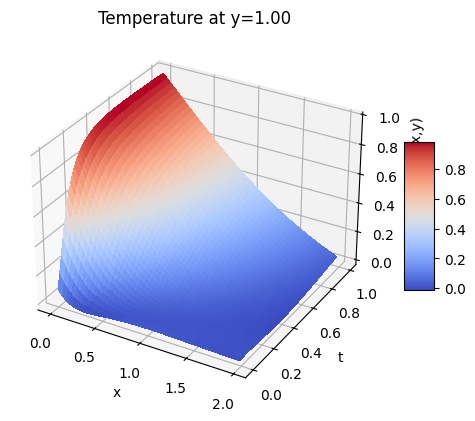

In [87]:
heat_equation.plot_y_forward()

In [93]:

from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def film_forward(net, conductivity=None, heat_source=None):
    x = np.arange(0, 2, 0.02)
    y = np.arange(0, 2, 0.02)
    t = np.arange(0, 1, 0.01)

    ms_x, ms_y, ms_t = np.meshgrid(x, y, t, indexing="ij")
    x_all = ms_x.ravel().reshape(-1, 1)
    y_all = ms_y.ravel().reshape(-1, 1)
    t_all = ms_t.ravel().reshape(-1, 1)

    pt_x = Variable(torch.from_numpy(x_all).float(), requires_grad=False).to(device)
    pt_y = Variable(torch.from_numpy(y_all).float(), requires_grad=False).to(device)
    pt_t = Variable(torch.from_numpy(t_all).float(), requires_grad=False).to(device)

    pt_u = net(pt_x, pt_y, pt_t)
    u = pt_u.data.cpu().numpy()
    ms_u = u.reshape((100, 100, 100))

    def update_plot(time_index):
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")

        ms_x_2d = ms_x[:, :, time_index]
        ms_y_2d = ms_y[:, :, time_index]
        ms_u_2d = ms_u[:, :, time_index]

        surf = ax.plot_surface(ms_x_2d, ms_y_2d, ms_u_2d, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.4, aspect=5)

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("Temperature u(x,y)")
        ax.set_title(f"Temperature at t={t[time_index]:.2f}")

        plt.show()

    # Utilisation du widget interact pour modifier time_index
    interact(update_plot, time_index=widgets.IntSlider(min=0, max=len(t)-1, step=1, value=0))


In [94]:
heat_equation.film_forward()

interactive(children=(IntSlider(value=0, description='time_index', max=99), Output()), _dom_classes=('widget-i…